In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# import datasets 
from torchvision import datasets, transforms

trans = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize( (0.1307,),(0.3081,))])

train_set = datasets.MNIST( './data', train=True, transform=trans, download=True )
test_set = datasets.MNIST( './data', train=False, transform=trans, download=True )


cpu


/home/betelgeuse/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [5]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=True)

print('total training batch number: {}'.format(len(train_loader)))
print('total testing batch number: {}'.format(len(test_loader)))

total training batch number: 600
total testing batch number: 100


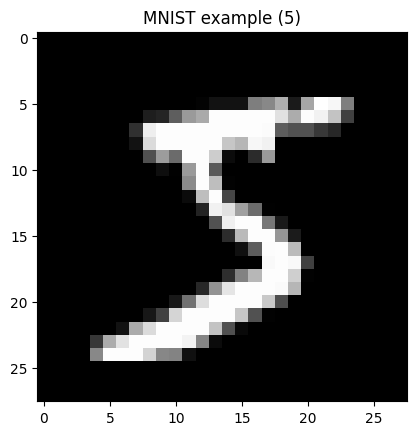

In [13]:
# display some images
# for an alternative see https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
def imshow(tensor, title=None):
    img = tensor.cpu().clone()
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.5)

plt.figure()
for ii in range(10):
    imshow(train_set.data[ii] , title='MNIST example ({})'.format(train_set.targets[ii]) )
    break
plt.close()

In [15]:
# define MLP model
DATA_SIZE = 28*28 
NUM_CLASSES = 10
NUM_HIDDEN_1 = 512 # try 512
NUM_HIDDEN_2 = 256

In [18]:
class RegSoftNet(nn.Module):
    def __init__(self):
        super(RegSoftNet, self).__init__()
        self.fc = nn.Linear(DATA_SIZE, NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # reshape the tensor
        x = self.fc(x)
        return x

In [20]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(DATA_SIZE, NUM_HIDDEN_1)
        self.fc2 = nn.Linear(NUM_HIDDEN_1, NUM_HIDDEN_2)
        self.fc3 = nn.Linear(NUM_HIDDEN_2, NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # reshape the tensor 
        x = self.fc1(x)
        x = nn.ReLU(x)
        x = self.fc2(x)
        x = nn.ReLU(x)
        x = self.fc3(x)
        return x

In [21]:
NUM_CONV_1=10
NUM_CONV_2=20
NUM_FC=500
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv_1 = nn.Conv2d(1,NUM_CONV_1,5,1) # kernel_size = 5
        self.conv_2 = nn.Conv2d(NUM_CONV_1,NUM_CONV_2,5,1) # kernel_size = 5
        self.fc_1 = nn.Linear(4*4*NUM_CONV_2, NUM_FC)
        self.fc_2 = nn.Linear(NUM_FC,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,4*4*NUM_CONV_2)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
        # en utilisant loss = F.nll_loss(output, target) on peut faire
        # return F.log_softmax(x, dim=1)

In [26]:
# define model (choose MLP or CNN)
model = RegSoftNet()
#model = MLPNet()
#model = CNNNet()

model.to(device) # puts model on GPU / CPU

# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

In [27]:

# main loop (train+test)
for epoch in range(10):
    # training
    model.train() # mode "train" agit sur "dropout" ou "batchnorm"
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))



epoch 0 batch 0 [0/60000] training loss: 2.3858625888824463
epoch 0 batch 100 [10000/60000] training loss: 0.3326517343521118
epoch 0 batch 200 [20000/60000] training loss: 0.4510713219642639
epoch 0 batch 300 [30000/60000] training loss: 0.2444605976343155
epoch 0 batch 400 [40000/60000] training loss: 0.45526179671287537
epoch 0 batch 500 [50000/60000] training loss: 0.3042195737361908
Accuracy: 9152/10000 (tx 91.52%, err 8.48%)

epoch 1 batch 0 [0/60000] training loss: 0.29187190532684326
epoch 1 batch 100 [10000/60000] training loss: 0.4004276394844055
epoch 1 batch 200 [20000/60000] training loss: 0.40749457478523254
epoch 1 batch 300 [30000/60000] training loss: 0.18579040467739105
epoch 1 batch 400 [40000/60000] training loss: 0.3847217857837677
epoch 1 batch 500 [50000/60000] training loss: 0.18494006991386414
Accuracy: 9180/10000 (tx 91.80%, err 8.20%)

epoch 2 batch 0 [0/60000] training loss: 0.2667606472969055
epoch 2 batch 100 [10000/60000] training loss: 0.2724877893924713